In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers, initializers
import matplotlib.pyplot as plt

2026-01-14 16:09:49.023304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768406989.247563      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768406989.306816      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768406989.826844      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768406989.826894      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768406989.826898      55 computation_placer.cc:177] computation placer alr

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
num_classes = 10
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes)

In [4]:
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return layers.Multiply()([input_tensor, se])

In [5]:
def optimized_res_block(x, filters, stride=1, use_se=True, drop_rate=0.0):
    shortcut = x
    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    
    if drop_rate > 0:
        x = layers.SpatialDropout2D(drop_rate)(x)
    
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    if use_se:
        x = se_block(x)
    
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False, kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = layers.Activation('gelu')(x)
    return x

In [6]:
inputs = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('gelu')(x)
x = layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('gelu')(x)

x = optimized_res_block(x, 128)
x = optimized_res_block(x, 128)
x = optimized_res_block(x, 128)
x = optimized_res_block(x, 128)

x = optimized_res_block(x, 256, stride=2, drop_rate=0.1)
x = optimized_res_block(x, 256, drop_rate=0.1)
x = optimized_res_block(x, 256, drop_rate=0.1)
x = optimized_res_block(x, 256, drop_rate=0.1)

x = optimized_res_block(x, 512, stride=2, drop_rate=0.2)
x = optimized_res_block(x, 512, drop_rate=0.2)
x = optimized_res_block(x, 512, drop_rate=0.2)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='gelu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.Dense(10)(x)

model = models.Model(inputs=inputs, outputs=x, name="Capacity_Enhanced_SE_ResNet")
model.summary()


I0000 00:00:1768407013.142502      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "Capacity_Enhanced_SE_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      3,456 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │    147,456 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    147,456 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,456 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 128) │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 8)   │      1,024 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 128) │      1,024 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ multiply[0][0], 

 Total params: 19,329,930 (73.74 MB)

 Trainable params: 19,315,594 (73.68 MB)

 Non-trainable params: 14,336 (56.00 KB)

In [7]:
BATCH_SIZE = 64 
steps_per_epoch = 50000 // BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=10 * steps_per_epoch,
    alpha=0.0
)

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=0.005 
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1), 
    metrics=['accuracy']
)

In [8]:
print("Start")
history = model.fit(
    train_images, train_labels_onehot,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=(test_images, test_labels_onehot),
    verbose=1
)

Start
Epoch 1/10


I0000 00:00:1768407040.863754     124 service.cc:152] XLA service 0x7bb9d8004c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768407040.863797     124 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768407045.503724     124 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/782 ━━━━━━━━━━━━━━━━━━━━ 10:13:14 47s/step - accuracy: 0.0781 - loss: 2.5048

I0000 00:00:1768407064.769750     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 176s 165ms/step - accuracy: 0.3563 - loss: 1.9082 - val_accuracy: 0.5719 - val_loss: 1.4251
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.6293 - loss: 1.3284 - val_accuracy: 0.6294 - val_loss: 1.3284
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.7320 - loss: 1.1065 - val_accuracy: 0.6655 - val_loss: 1.2615
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.8041 - loss: 0.9649 - val_accuracy: 0.8029 - val_loss: 0.9489
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.8498 - loss: 0.8573 - val_accuracy: 0.8232 - val_loss: 0.8995
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.8898 - loss: 0.7691 - val_accuracy: 0.8640 - val_loss: 0.8208
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - accuracy: 0.9195 - loss: 0.7019 - val_accuracy: 0.8690 - val_loss: 0.8030
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - accuracy: 0.9518 - loss: 0.63

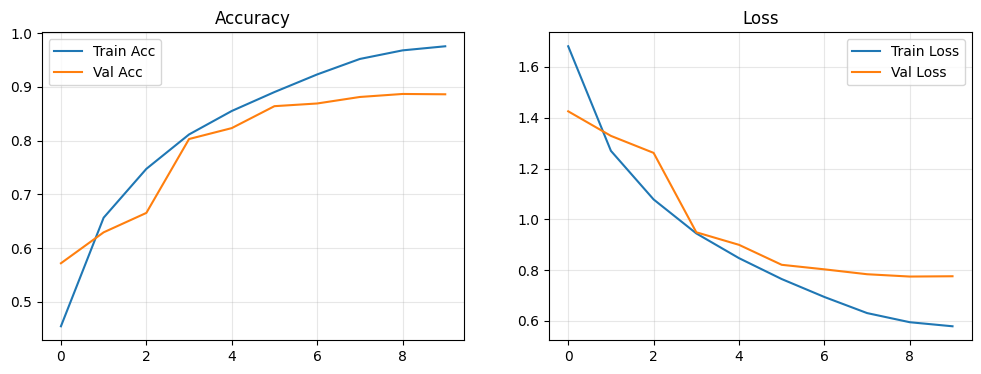


KẾT QUẢ CAPACITY ENHANCED:
Test Accuracy: 0.8860999941825867
Test Loss: 0.7757613062858582


In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels_onehot, verbose=0)
print(f"\n{'='*50}")
print(f"KẾT QUẢ CAPACITY ENHANCED:")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")
print(f"{'='*50}")